In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import os

In [4]:
p = 'decoding_times_out_new/'
file_names = os.listdir(p)
file_names = [file for file in file_names if file[0] == 'W']
print('Total number of files in folder is ' + str(len(file_names) + 1))

Total number of files in folder is 3072


In [3]:
####assemble normalised data into data frames

#function to read in modelled decoding time data and normalise to mean
def read_rrt(p,file_name):
    df = pd.read_csv(p + file_name)
    av_dt = np.mean(df['average_decoding_time'])
    if not 'W' in file_name:
        colname = 'base config'
    else:
        colname = file_name[:-4].replace('Wo_','')
    df[colname] = df['average_decoding_time'] / av_dt
    
    return df[['codon',colname]]

#read in filenames
p = 'decoding_times_out_new/'
file_names = os.listdir(p)
file_names = [file for file in file_names if file[0] == 'W']

#initiate dataframe with baseline data
norm_df = read_rrt(p,'base_configuration.csv')
for file_name in file_names:
    add_df = read_rrt(p,file_name)
    norm_df = norm_df.merge(add_df,on='codon')

#read in experimental RRT file names
p = 'Codon data/'
file_names = os.listdir(p)
file_names = [file for file in file_names if file[0] != '.']

#add experimental RRT data (RRTs are already normalised)
for file_name in file_names:
    add_df = pd.read_csv(p + file_name)
    add_df['codon'] = add_df['codon'].str.replace('T','U')
    add_df.columns = [add_df.columns[0],file_name[:-4]]
    norm_df = norm_df.merge(add_df,on='codon')

norm_df = norm_df.set_index('codon')
norm_df = norm_df.iloc[:,0:].T
norm_df.to_csv('modelled_rrts.csv')

In [6]:
#reload data if not computed above
#norm_df = pd.read_csv('modelled_rrts.csv',index_col=0)

<h2>Principal Components</h2>

In [5]:
#explore how much variance is explained when dimensions are reduced using pca

#remove the experimental rrt data for this analysis
pca_df = norm_df
for sample_name in pca_df.index:
    if '20' in sample_name:
        pca_df = pca_df.drop(sample_name,axis=0)

var_ratio = []
for dim in range(norm_df.shape[1]):
  this_pca = PCA(n_components=dim)
  this_pca.fit(norm_df)
  var_ratio.append(np.sum(this_pca.explained_variance_ratio_))

In [6]:
#test which codons contribute most to the information in high dimensional space
test_pca = PCA(n_components=3)
base_pca_result = test_pca.fit(pca_df)
base_evr = np.sum(base_pca_result.explained_variance_ratio_)
codons,d_evrs = [],[]
for codon in pca_df.columns:
    temp_df = pca_df.drop(codon,axis=1)
    test_pca_result = test_pca.fit(temp_df)
    codons.append(codon)
    d_evrs.append(np.sum(base_pca_result.explained_variance_ratio_) - base_evr)

test_results = pd.DataFrame({'codon':codons,'d_evr':d_evrs})
test_results = test_results.sort_values('d_evr',ascending=False)

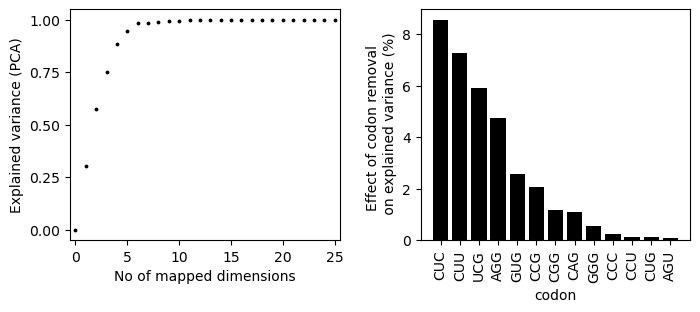

In [7]:
#exclude data between +- 0.001
x,y = [],[]
for row in test_results.iterrows():
    if row[1]['d_evr'] > 0.001:
        x.append(row[1]['codon'])
        y.append(row[1]['d_evr']*100)

fig,ax = plt.subplots(1,2,figsize = (8,3))
ax[0].scatter(range(pca_df.shape[1]),var_ratio,s=3,c='black')
ax[0].set_xlabel('No of mapped dimensions')
ax[0].set_ylabel('Explained variance (PCA)')
ax[0].set_xlim((-0.5,25.5))
ax[0].set_yticks([0,0.25,0.5,0.75,1])
ax[1].bar(x,y,color='black')
ax[1].set_xlabel('codon')
ax[1].set_ylabel('Effect of codon removal \n on explained variance (%)')
ax[1].tick_params(axis='x', labelrotation=90)
fig.subplots_adjust(wspace=0.3)
plt.savefig('Figure pca analyses.svg')
plt.show()

<h2>MDS</h2>

In [9]:
#fit 2D mds
norm_mds = MDS(n_components=2,normalized_stress='auto',metric=True)
norm_mds_data = norm_mds.fit_transform(norm_df)

#identify MDs clusters
get_mds_clusters = DBSCAN(eps=0.2, min_samples=10).fit(norm_mds_data)

#compare distances in original and 2D datasets
mds_comp_x = euclidean_distances(norm_mds_data).flatten()
mds_comp_y = euclidean_distances(norm_df).flatten()

Text(0.5, 0, 'Dimension 1')

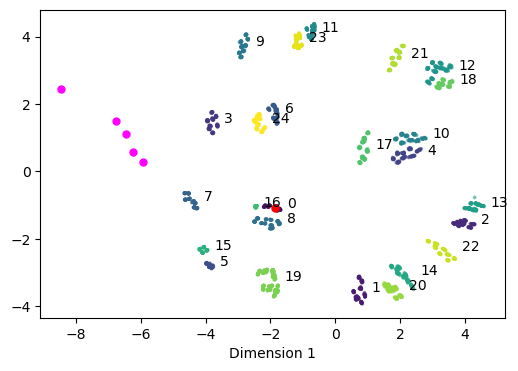

In [10]:
###Plot results

x = norm_mds_data.T[0]
y = norm_mds_data.T[1]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y,s=3,c=get_mds_clusters.labels_,cmap='viridis',alpha = 0.5)
ax.scatter(x[0],y[0],c='red',s=25)
ax.scatter(x[-5:],y[-5:],c='fuchsia',s=25)
#label individual clusters with their cluster number
for n in range(max(get_mds_clusters.labels_)+1):
    select_x = [a[0] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    select_y = [a[1] for i,a in enumerate(norm_mds_data) if get_mds_clusters.labels_[i] == n]
    ax.text(max(select_x) + 0.2,np.mean(select_y),str(n))
ax.set_xlabel('Dimension 1')

In [11]:
def count_bp_labels(n):
    bp_labels = norm_df.index
    cluster_bp_labels = [bl for i,bl in enumerate(bp_labels) if get_mds_clusters.labels_[i] == n]
    results = {}
    for cbl in cluster_bp_labels:
        cbl_elements = cbl.split(' ')
        for el in cbl_elements:
            if el in results.keys():
                results[el] += 1
            else:
                results[el] = 1
    return results

In [12]:
#change the number assigned to n in order to see the composition of different clusters
n = 1
print('label no:' + str(n) + '.' + str(np.sum([1 for l in get_mds_clusters.labels_ if l == n])) + ' data points.')
print(count_bp_labels(n))

label no:1.128 data points.
{'A_A': 64, 'C_U': 128, 'G_&': 64, 'G_1': 64, 'G_N': 128, 'G_P': 64, 'G_?': 64, 'U_U': 128, 'G_~': 64, 'U_I': 64}


<h2>Modified nucleotide symbols</h2>
<table>
    <td>
        <ul>
            <li>1: mcm5U</li>
            <li>3: mcm5s2U</li>
            <li>I: inosine</li>
            <li>M: ac4C</i>
            <li>N: unkown modified U</li>
            <li>P: pseudouridine</li>
        </ul>
    </td>
    <td>
        <ul>        
            <li>Q: queuosine</li>
            <li>S: mnm5s2U</li>
            <li>V: cmo5U</li>
            <li>W: wybutosine</li>
            <li>{: mnm5U</li>
            <li>): cmnm5Um</li>
        </ul>
    </td>
    <td>
        <ul>
            <li>&: ncm5U</li>
            <li>~: ncm5Um</li>
            <li>.: unknown nucleotide</li>
            <li>?: m5C</li>
        </ul>
    </td>
</table>

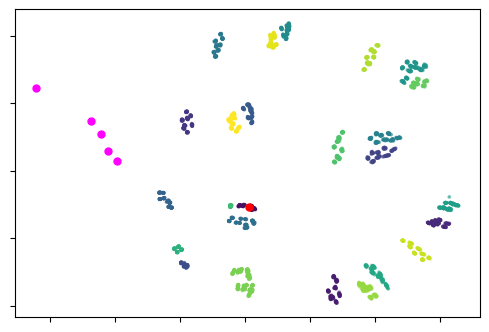

In [13]:
#plot .png version of figure without furniture to generate publication figure
#(svg version is ~300 mb)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y,s=3,c=get_mds_clusters.labels_,cmap='viridis',alpha = 0.5)
ax.scatter(x[0],y[0],c='red',s=25)
ax.scatter(x[-5:],y[-5:],c='fuchsia',s=25,)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('mds_bare.png',dpi=600)
plt.show()


<h2>Distance changes</h2>

In [14]:
idces = norm_df.index[1:-5]
unique_elements = []
for idx in idces:
    for el in idx.split(' '):
        if el not in unique_elements:
            unique_elements.append(el)

In [15]:
#define the indices of the literature rrt samples
rrts = list(norm_df.index[-5:])
#prepare a dictionary to hold results
res_dic = {}
#cycle through all unique base pairs:
for e in unique_elements:
    if e not in ['G_','A_']:
        #find all indices that contain this base pair
        has_e = [idx for idx in idces if e in idx]
        delta_dists = []
        #cycle through all indices that have the base pair of interest
        for search_e in has_e:
            #find comparator
            search_set = [search_e_element for search_e_element in search_e.split(' ') if search_e_element != e]
            if len(search_set) == 0:
                comparator = 'base config'
            elif len(search_set) ==1:
                comparator = search_set[0]
            else:
                if ' '.join(search_set) in idces:
                    comparator = ' '.join(search_set)
                else:
                    inv_search_set = [search_set[1],search_set[0]]
                    if ''.join(inv_search_set) in idces:
                        comparator = ''.join(inv_search_set)
            #determine the euclidean distance between search index and literature rrts
            euclid_search_df = norm_df.loc[[search_e] + rrts]
            shift_dist = np.mean(euclidean_distances(euclid_search_df)[0][1:])
            euclid_comp_df = norm_df.loc[[comparator] + rrts]
            comp_dist = np.mean(euclidean_distances(euclid_comp_df)[0][1:])
            delta_dists.append((shift_dist - comp_dist)/ comp_dist)
        res_dic[e] = delta_dists
#clean up dictionary
key_lengths = []
for key in res_dic.keys():
    key_lengths.append(len(res_dic[key]))
max_key_length = max(key_lengths)

In [16]:
for key in res_dic.keys():
    actual_key_length = len(res_dic[key])
    res_dic[key] = res_dic[key] + [np.nan]*(max_key_length-actual_key_length)
res_df = pd.DataFrame(res_dic)
res_df = res_df.reindex(res_df.mean().sort_values().index, axis=1)

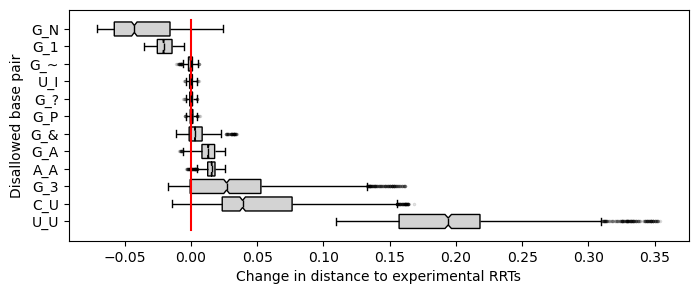

In [17]:
fig,ax = plt.subplots(figsize = (8,3))

sns.boxplot(ax=ax,data=res_df,orient='h',color = 'lightgrey',linecolor='black',notch=True,
               flierprops={'marker':'.','ms':3,'alpha':0.15})
ax.set_xticks((-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35))
ax.plot((0,0),(-0.5,11.5),color='red')
ax.set_xlabel('Change in distance to experimental RRTs')
ax.set_ylabel('Disallowed base pair')
plt.savefig('Base pair movement.svg')
plt.show()